In [1]:
import shutil
import pathlib
import tempfile
import tensorflow_docs.plots
import tensorflow_docs.modeling

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs as tfdocs

from  IPython import display
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
# For tensorboard loggin

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors = True)

In [3]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [4]:
FEATURES = 28

In [5]:
ds = tf.data.experimental.CsvDataset(gz ,[float(),]*(FEATURES+1), compression_type = "GZIP")

In [6]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [7]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


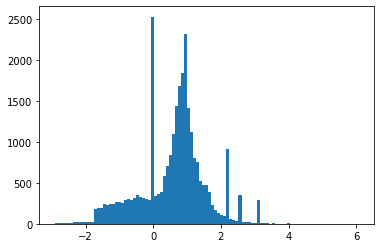

In [8]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [9]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [10]:
# Dataset.cache ensures we don't have to reload dataset on each epoch

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [11]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [12]:
# Get optimizer as an LR Scheduler

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps = STEPS_PER_EPOCH*1000,
  decay_rate = 1,
  staircase = False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

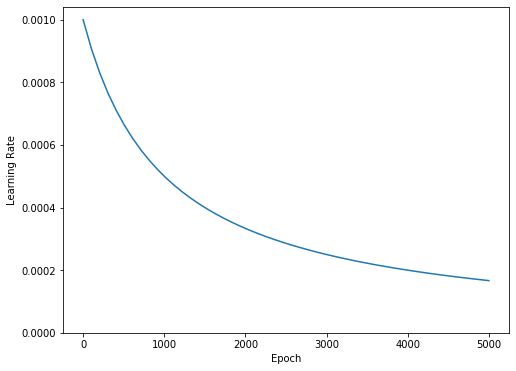

In [13]:
# See decay on plot

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [14]:
def get_callbacks(name):
    
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor = 'val_binary_crossentropy', patience = 200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [15]:
def compile_and_fit(model, name, optimizer = None, max_epochs = 10000):
    
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer = optimizer,
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = [
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits = True, name = 'binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = max_epochs,
    validation_data = validate_ds,
    callbacks = get_callbacks(name),
    verbose = 0)

  return history

# Show overfit

Very tiny model as a starter

In [16]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation = 'elu', input_shape = (FEATURES,)),
    layers.Dense(1)
])

In [17]:
size_histories = {}

In [18]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5221,  binary_crossentropy:0.8934,  loss:0.8934,  val_accuracy:0.4820,  val_binary_crossentropy:0.8016,  val_loss:0.8016,  
....................................................................................................
Epoch: 100, accuracy:0.5923,  binary_crossentropy:0.6282,  loss:0.6281,  val_accuracy:0.5840,  val_binary_crossentropy:0.6257,  val_loss:0.6257,  
....................................................................................................
Epoch: 200, accuracy:0.62

(0.5, 0.7)

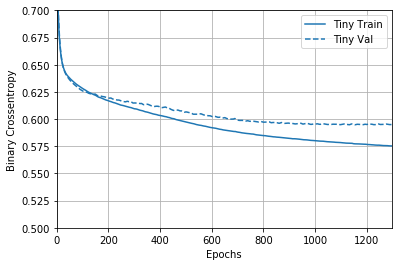

In [19]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std = 10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

Small Model 

In [20]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape = (FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [21]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', optimizer = 'adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5059,  binary_crossentropy:0.7582,  loss:0.7582,  val_accuracy:0.4770,  val_binary_crossentropy:0.7408,  val_loss:0.7408,  
....................................................................................................
Epoch: 100, accuracy:0.6100,  binary_crossentropy:0.6180,  loss:0.6180,  val_accuracy:0.5790,  val_binary_crossentropy:0.6264,  val_loss:0.

In [22]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [23]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium", optimizer = 'adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4915,  binary_crossentropy:0.6931,  loss:0.6931,  val_accuracy:0.4820,  val_binary_crossentropy:0.6840,  val_loss:0.6840,  
....................................................................................................
E